# H5AD output

In [1]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects

from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

In [57]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

vdata = AnnData(X=expr_x, var=var, obs=obs)

In [58]:
vdata

AnnData object with n_obs × n_vars = 40952 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y'

## Add more meta info

In [29]:
# add batch information 
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'batch'] = 'batch_1'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'batch'] = 'batch_1'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'batch'] = 'batch_2'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'batch'] = 'batch_2'

# add time information 
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'time'] = '8_months'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'time'] = '8_months'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'time'] = '13_months'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'time'] = '13_months'

# add group information 
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9721', 'group'] = 'disease'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9781', 'group'] = 'control'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9919', 'group'] = 'disease'
vdata.obs.loc[adata.obs['sample'] == 'AD_mouse9930', 'group'] = 'control'

# change dtype
vdata.obs['sample'] = vdata.obs['sample'].astype('category')
vdata.obs['sample'] = vdata.obs['sample'].cat.reorder_categories(['AD_mouse9781', 'AD_mouse9721', 'AD_mouse9930', 'AD_mouse9919'])

vdata.obs['batch'] = vdata.obs['batch'].astype('category')
vdata.obs['batch'] = vdata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

vdata.obs['time'] = vdata.obs['time'].astype('category')
vdata.obs['time'] = vdata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

vdata.obs['group'] = vdata.obs['group'].astype('category')

IndexingError: (1         True
3         True
4         True
5         True
6         True
         ...  
40944    False
40945    False
40946    False
40947    False
40949    False
Name: sample, Length: 36625, dtype: bool, 'batch')

## Filtration

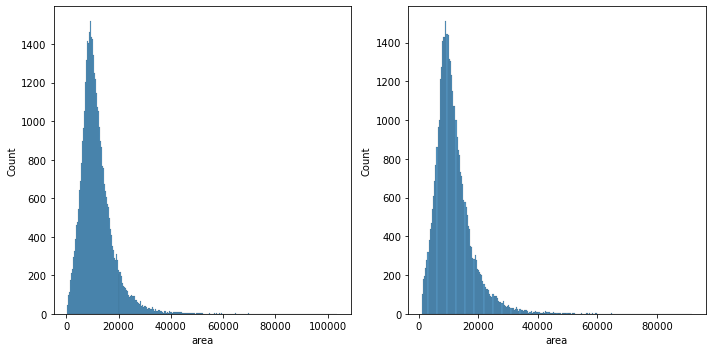

Trying to set attribute `.obs` of view, copying.


Number of cell left: 40824


(36625, 13)

In [59]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(vdata, percent_top=None, inplace=True)
vdata.var['max_counts'] = vdata.X.max(axis=0)

# Filter cell by area 
vdata = su.filter_cells_by_area(vdata, min_area=1000, max_area=100000, save=False)

# Filtration 
sc.pp.filter_cells(vdata, min_genes=10)
sc.pp.filter_genes(vdata, min_cells=10)

sc.pp.filter_cells(vdata, min_counts=73)
sc.pp.filter_cells(vdata, max_counts=1500)

vdata.obs.shape

## Add prediction 

In [16]:
adata = sc.read_h5ad('../2020-10-09-mAD-reads-assignment/output/2020-12-27-starmap-mAD-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 33106 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [17]:
# load predictions 
# top-level
prediction_top_level = pd.read_csv('output/integration/predicted_top_level.csv')

vdata.obs['predicted_top_level'] = prediction_top_level['predicted.id'].values
vdata.obs['predicted_top_level_score'] = prediction_top_level['prediction.score.max'].values

# cell-type
prediction_cell_type = pd.read_csv('output/integration/predicted_cell_type.csv')

vdata.obs['predicted_cell_type'] = prediction_cell_type['predicted.id'].values
vdata.obs['predicted_cell_type_score'] = prediction_cell_type['prediction.score.max'].values

# cell-type-label
prediction_cell_type_label = pd.read_csv('output/integration/predicted_cell_type_label.csv')

vdata.obs['predicted_cell_type_label'] = prediction_cell_type_label['predicted.id'].values
vdata.obs['predicted_cell_type_label_score'] = prediction_cell_type_label['prediction.score.max'].values

In [18]:
vdata.uns['top_level_order'] = adata.uns['top_level_order']
vdata.uns['top_hex_dict'] = adata.uns['top_hex_dict']
vdata.uns['top_rgb_dict'] = adata.uns['top_rgb_dict']

vdata.uns['cell_type_order'] = adata.uns['cell_type_order']
vdata.uns['sub_hex_dict'] = adata.uns['sub_hex_dict']
vdata.uns['sub_rgb_dict'] = adata.uns['sub_rgb_dict']

vdata.uns['cell_type_label'] = adata.uns['cell_type_label']
vdata.uns['label_hex_dict'] = adata.uns['label_hex_dict']
vdata.uns['label_rgb_dict'] = adata.uns['label_rgb_dict']

In [19]:
vdata.obs['predicted_top_level'] = vdata.obs['predicted_top_level'].astype('category')
vdata.obs['predicted_top_level'] = vdata.obs['predicted_top_level'].cat.reorder_categories(vdata.uns['top_level_order'])

current_cell_type_order = [c for c in vdata.uns['cell_type_order'] if c in vdata.obs['predicted_cell_type'].unique()]
vdata.obs['predicted_cell_type'] = vdata.obs['predicted_cell_type'].astype('category')
vdata.obs['predicted_cell_type'] = vdata.obs['predicted_cell_type'].cat.reorder_categories(current_cell_type_order)

current_cell_label_order = [c for c in vdata.uns['cell_type_label'] if c in vdata.obs['predicted_cell_type_label'].unique()]
vdata.obs['predicted_cell_type_label'] = vdata.obs['predicted_cell_type_label'].astype('category')
vdata.obs['predicted_cell_type_label'] = vdata.obs['predicted_cell_type_label'].cat.reorder_categories(current_cell_label_order)

## Add obs

In [60]:
adata = sc.read_h5ad('./output/2021-04-12-starmap-mAD-64-genes-scaled.h5ad')
adata

AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'batch_colors', 'cell_type_label', 'cell_type_order', 'group_colors', 'label_hex_dict', 'label_rgb_dict', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'predicted_top_level_colors', 'rank_genes_groups', 'sample_colors', 'sub_hex_dict', 'sub_rgb_dict', 'time_colors', 'top_hex_dict', 'top_hex_dic

In [61]:
vdata.obs = adata.obs
vdata.var = adata.var
vdata.uns = adata.uns

In [62]:
vdata.uns['top_hex_dict_64']['Mix'] = '#ededed'
vdata.uns['top_rgb_dict_64']['Mix'] = np.array([0.9294117647058824, 0.9294117647058824, 0.9294117647058824])

In [63]:
# Update tau 
for sample in sorted(vdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    labels = vdata.uns[current_key]['label_img']
    tau = vdata.uns[current_key]['tau'] > 1
    current_index = vdata.obs.loc[vdata.obs['sample'] == sample, 'orig_index'].values
    tau_intensity = []
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        if i in current_index:
            # tau intensity
            curr_intensity = np.sum(tau[region.coords[:, 0], region.coords[:, 1]])
            curr_intensity = curr_intensity / region.area * 100
            tau_intensity.append(round(curr_intensity, 2))
    vdata.obs.loc[vdata.obs['sample'] == sample, 'tau'] = tau_intensity

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


## Add images

In [21]:
# Load data and store the information to uns
for sample in sorted(vdata.obs['sample'].unique()):
    print(sample)
    
    # Segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Plaque
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Tau
    current_tau_path = os.path.join(sample, 'scaled/tau.tif')
    current_tau = tifffile.imread(current_tau_path)
    current_tau = gaussian(current_tau.astype(np.float), 2) > 30
        
        
    # Load Gfap img
    current_gfap_path = os.path.join(sample, 'scaled/Gfap.tif')
    current_gfap = tifffile.imread(current_gfap_path)
    gfap_threshold = threshold_otsu(current_gfap)
    current_gfap = gaussian(current_gfap.astype(np.float), 1) > gfap_threshold

#     # Region
#     current_region_path = os.path.join(sample, 'segmentation/scaled/bill-labels.tif')
#     current_region_img = tifffile.imread(current_region_path)

    # Morph
    current_key = f"{sample}_morph"
    vdata.uns[current_key] = {}
    vdata.uns[current_key]['label_img'] = current_img
    vdata.uns[current_key]['plaque'] = current_plaque
    vdata.uns[current_key]['tau'] = current_tau
    vdata.uns[current_key]['gfap'] = current_gfap
#     vdata.uns[current_key]['region'] = current_region_img

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [22]:
# Scale x and y 
vdata.obs['x'] = vdata.obs['x'] * .3
vdata.obs['x'] = vdata.obs['x'].astype(int)
vdata.obs['y'] = vdata.obs['y'] * .3
vdata.obs['y'] = vdata.obs['y'].astype(int)

In [23]:
vdata

AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    uns: 'top_level_order', 'top_hex_dict', 'top_rgb_dict', 'cell_type_order', 'sub_hex_dict', 'sub_rgb_dict', 'cell_type_label', 'label_hex_dict', 'label_rgb_dict', 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph'

## Save raw

In [64]:
# Save
vdata.write_h5ad('./output/2021-04-14-starmap-mAD-64-genes-raw.h5ad')

## Normalization & Scaling

In [65]:
# Normalization scaling
sc.pp.normalize_total(vdata)
sc.pp.log1p(vdata)

vdata.raw = vdata

In [66]:
# Scale data to unit variance and zero mean
sc.pp.scale(vdata)
vdata.layers['scaled'] = vdata.X

# Batch correction
sc.pp.combat(vdata)
vdata.layers['corrected'] = vdata.X

## Save scaled

In [67]:
# Save
vdata.write_h5ad('./output/2021-04-14-starmap-mAD-64-genes-scaled.h5ad')